In [1]:
using QuantumToolbox
using PlotlyJS
using FFTW

In [2]:
N = 20 # dimension of cavity

ωr = 2 * 2π # resonator frequency
ωq = 3 * 2π # qubit frequency
χ = 0.025 * 2π # qubit-resonator coupling strength

Δ = abs(ωr - ωq) # detuning -- small in the RWA 
g = sqrt(Δ * χ); # coupling strength that is consistent with chi

In [3]:
# comparing the detuning to the dispersion:
Δ, g

(6.283185307179586, 0.99345882657961)

Detuning is much larger than the coupling strength, as necessary in dispersive regime. 

In [4]:
# make the dispersive Hamiltonian
# hilbert space is ordered such that (cavity ⊗ qubit)
a = destroy(N) ⊗ qeye(2)
nc = a' * a # number operator
xc = a + a' # dipole operator of cavity

# system operators
σm = qeye(N) ⊗ destroy(2) # sigma minus
σz = qeye(N) ⊗ sigmaz() # sigma z
σx = qeye(N) ⊗ sigmax() # sigma x
nq = σm' * σm # number operator of qubit
xq = σm + σm' # dipole operator of qubit

I = qeye(N) ⊗ qeye(2) # identity operator

# dispersive Hamiltonian
H_dispersive = ωr * (nc + I/2.) + ωq/2. * σz + χ * (nc + I/2.) * σz;

# full Hamiltonian
H_full = ωr * (a' * a + I/2.) + ωq/2 * σz + g * (a' + a) * σx;

# there is no time-dependent drive on the cavity mode

Quantum Object:   type=Operator   dims=[20, 2]   size=(40, 40)   ishermitian=true
40×40 SparseMatrixCSC{ComplexF64, Int64} with 116 stored entries:
⎡⡱⢎⡠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠊⡱⢎⡠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠊⡱⢎⡠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠊⡱⢎⡠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠊⡱⢎⡠⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠊⡱⢎⡠⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠊⡱⢎⡠⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠊⡱⢎⡠⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠊⡱⢎⡠⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠊⡱⢎⎦

In [5]:
# initialize state
α = 2.
ψ0 = tensor(coherent(N, α) ⊗ normalize!(basis(2, 1) + basis(2,0))); # just some state

In [6]:
# time-evolve using mesolve
tlist = 0:0.1:250
e_ops = [nc, nq, a] # expectation values to compute
result = mesolve(H_dispersive, ψ0, tlist, [], e_ops=e_ops);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)


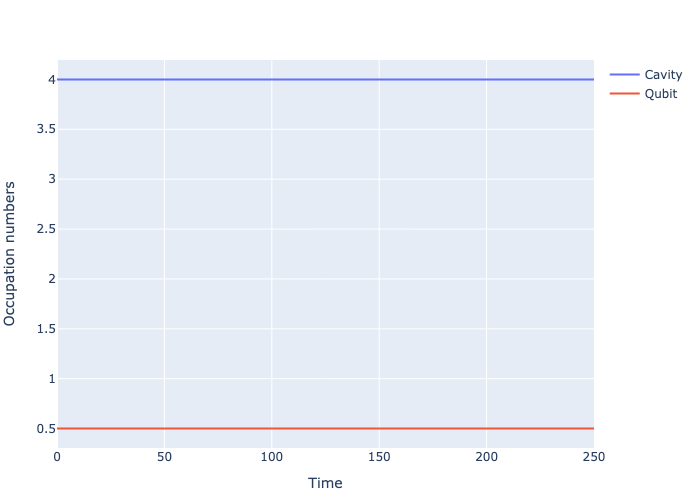

In [7]:
# plot the photon numbers of both the cavity and the qubit
nc_plot = scatter(x=tlist, y=real(result.expect[1,:]), name="Cavity")
nq_plot = scatter(x=tlist, y=real(result.expect[2,:]), name="Qubit")

layout = Layout(yaxis_title="Occupation numbers", xaxis_title="Time")

plot([nc_plot, nq_plot], layout)

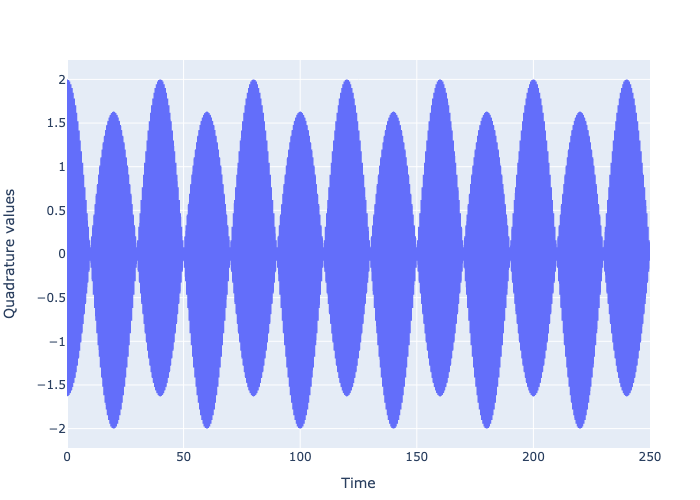

In [8]:
# plot the cavity quadrature
Xc = real(result.expect[3,:])
Pc = imag(result.expect[3,:])

Xc_plot = scatter(x=tlist, y=Xc, name="Xc")
Pc_plot = scatter(x=tlist, y=Pc, name="Pc")

layout = Layout(yaxis_title="Quadrature values", xaxis_title="Time")

plot([Xc_plot], layout)

In [9]:
# we now plot the correlation function
tlist = 0:0.1:1000

corr = correlation_2op_1t(H_dispersive, ψ0, tlist, a', a);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 14s (ETA: 0h 00m 00s)


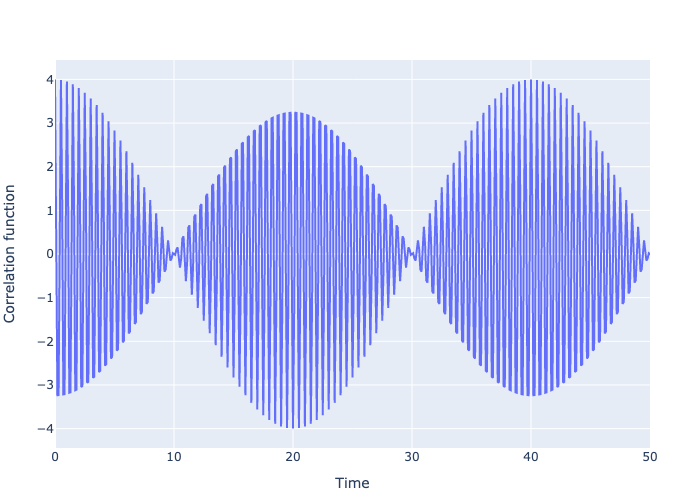

In [10]:
# plot the correlation function
corr_plot = scatter(x=tlist, y=real(corr), name="Correlation function")

layout = Layout(yaxis_title="Correlation function", xaxis_title="Time", xaxis=attr(range=[0, 50]))
plot([corr_plot], layout)

In [11]:
# spectrum of resonator
# spectrum is just the Fourier transform of the correlation function
S = fftshift(fft(corr));

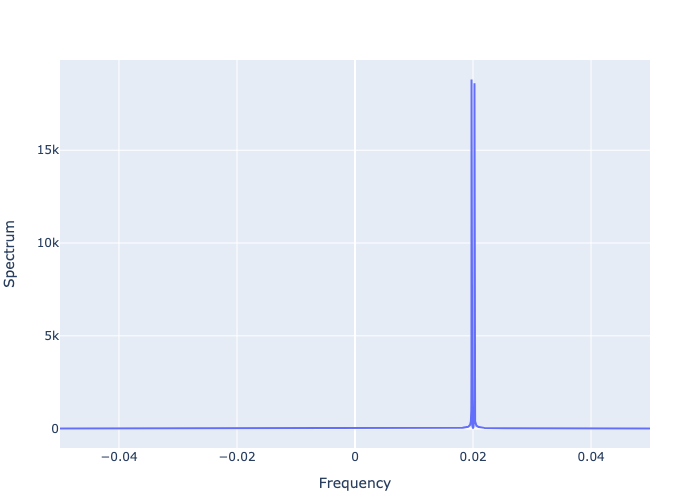

In [15]:
# plot the spectrum
f = fftshift(fftfreq(length(tlist), tlist[2] - tlist[1]));
S_plot = scatter(x=f, y=abs.(S), name="Spectrum")

layout = Layout(yaxis_title="Spectrum", xaxis_title="Frequency")

plot([S_plot], layout)

In [101]:
# now repeat for the qubit modes
corr_qubit = correlation_2op_1t(H_dispersive, ψ0, tlist, σx, σx);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)


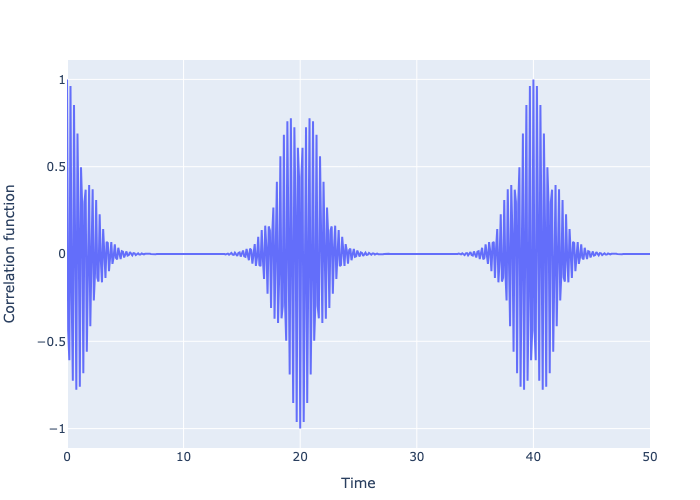

In [102]:
# plot the correlation function
corr_qubit_plot = scatter(x=tlist, y=real(corr_qubit), name="Correlation function")

layout = Layout(yaxis_title="Correlation function", xaxis_title="Time", xaxis=attr(range=[0, 50]))
plot([corr_qubit_plot], layout)

In [103]:
# get spectrum of qubit
S_qubit = fft(corr_qubit);

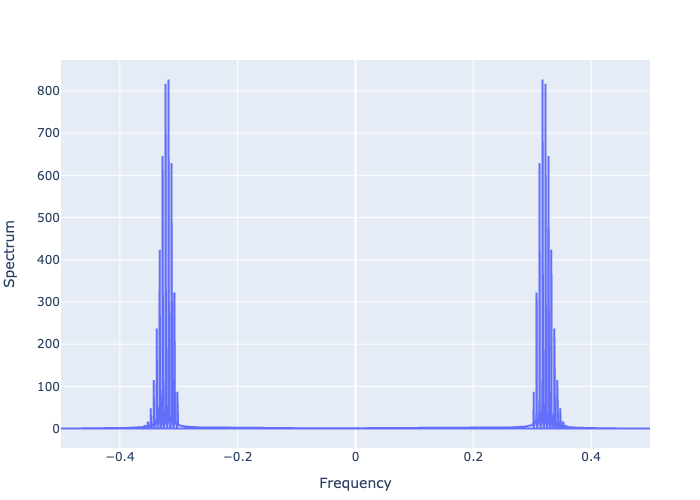

In [108]:
# plot the spectrum
f = fftfreq(length(tlist), tlist[2] - tlist[1]) / (tlist[2] - tlist[1])
S_plot = scatter(x=f, y=abs.(S_qubit), name="Spectrum")

layout = Layout(yaxis_title="Spectrum", xaxis_title="Frequency")

plot([S_plot], layout)

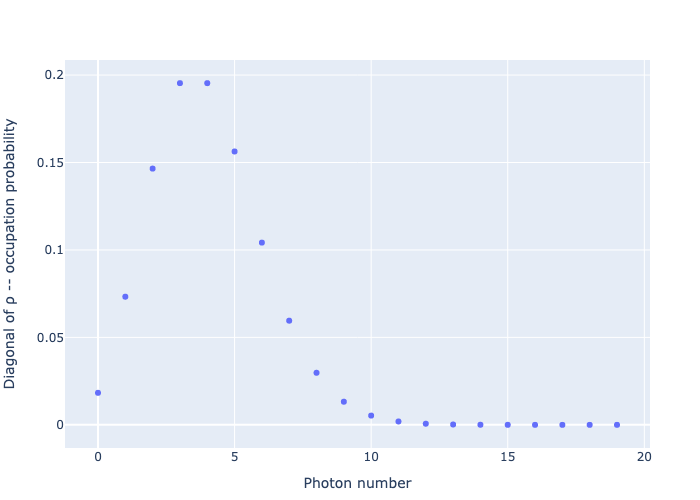

In [105]:
# get the partial trace of the cavity
ρ_cavity = ptrace(result.states[end], 1)

# plot the diagonals of ρ
diag_plot = scatter(x=0:N-1, y=real(diag(ρ_cavity)), mode="markers")

layout = Layout(yaxis_title="Diagonal of ρ -- occupation probability", xaxis_title="Photon number")

plot([diag_plot], layout)

In [106]:
# function to plot the wigner function
function plot_wigner(rho,xx,yy)
    layout = Layout(
        xaxis_title="Re(β)",
        yaxis_title="Im(β)",
        title="Wigner function",
        width=500,
        height=500
    )
    
    w = wigner(rho, xx, yy);
    vbound = maximum(abs.(w))

    custom_colorscale = [
        [0, "blue"],   # Negative values to blue
        [0.5, "white"],  # Zero values to white
        [1, "red"],     # Positive values to red
    ]

    heatmap_trace = heatmap(
        z=w,
        x=xx,
        y=yy,
        colorscale=custom_colorscale,
        showscale=true,
        zmin = -vbound,
        zmax = vbound
    )

    plot(heatmap_trace, layout)
end;

After interacting with the qubit, the cavity is no longer in a coherent state but rather in a superposition of coherent states. 

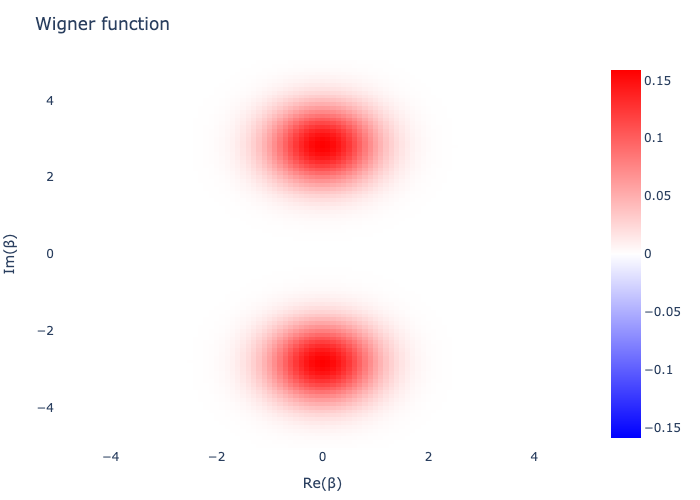

In [107]:
# now plot the wigner function of this same cavity state
xvec = -5:0.1:5
W = wigner(ρ_cavity, xvec, xvec)

plot_wigner(ρ_cavity, xvec, xvec)

Everything looks good!